In [1]:
import pickle as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.lines import Line2D
from matplotlib.ticker import AutoMinorLocator
plt.rcParams["text.usetex"] =True

# Evaluation
## Helper Methods

In [2]:
# the jaccard distance to measure how the recommendation lists change
def jaccard_distance(x, y):
    return 1 - len(set(x).intersection(y)) / len(set(x).union(y))

# average the results of our evaluation metrics over all seeds
def average_results(results):
    return np.mean([np.mean([results_f[uid] for uid in results_f]) for idx, results_f in enumerate(results)])

# by sorting the recommendation files (.pkl), we can ensure that all methods process the files in the same order
def sort_files(path):
    base, dataset_name, model_name, eps = path.split(sep="/")
    files = []
    for file in os.listdir(path):
        if file.endswith(".pkl"):
            files.append(file)

    LEN_PREFIX = len(model_name) + 1
    LEN_SUFFIX = len(".pkl")
    timestamps = [filename[LEN_PREFIX:-LEN_SUFFIX] for filename in files]
    sorted_timestamps = sorted(timestamps)
    sorted_files = [model_name + "-" + timestamp + ".pkl" for timestamp in sorted_timestamps]

    return sorted_files

# compute the evaluation metrics, i.e., recall, arp, and popularity lift
def _compute_metrics(recommendation_list, item_popularity, groundtruth, user_profile_popularity, impacted_users=None):
    recall, arp, upp = dict(), dict(), dict()
    poplift = []
    for uid, recs in recommendation_list.items():
        if impacted_users is not None:
            if uid not in impacted_users:
                continue

        recall[uid] = len(groundtruth.loc[uid].intersection([str(iid) for iid in recs])) / len(groundtruth.loc[uid])
        arp[uid] = np.mean([item_popularity.loc[str(item_id)] for item_id in recs])
        upp[uid] = user_profile_popularity.loc[uid]

    # poplift is based on user groups, not single users
    poplift.append((np.mean(list(arp.values())) - np.mean(list(upp.values()))) / np.mean(list(upp.values())))
    return recall, arp, np.mean(poplift)


# compute evaluation metrics across different seeds/files
def _analyze_recommendations(dirpath, item_popularity, groundtruth, user_profile_popularity, impacted_users=None):
    files = sort_files(dirpath)
    recalls, arps, poplifts = [], [], []
    for idx, file in enumerate(files):
        with open(dirpath + "/" + file, "rb") as f:
            recommendation_list = pl.load(f)
        if impacted_users is not None:
            recall, arp, poplift = _compute_metrics(recommendation_list, item_popularity, groundtruth, user_profile_popularity, impacted_users=impacted_users[idx])
        else:
            recall, arp, poplift = _compute_metrics(recommendation_list, item_popularity, groundtruth, user_profile_popularity)

        recalls.append(recall)
        arps.append(arp)
        poplifts.append(poplift)

    return recalls, arps, poplifts

# obtain the set of impacted user (per seed/file)
def _get_impacted_users(dirpath_nodp, dirpath_dp):
    files_nodp = sort_files(dirpath_nodp)
    files_dp = sort_files(dirpath_dp)

    impacted_users, frac_impacted_users, avg_dist = [], [], []
    for file_nodp, file_dp in zip(files_nodp, files_dp):
        with open(dirpath_nodp + "/" + file_nodp, "rb") as f:
            recommendation_list_nodp = pl.load(f)

        with open(dirpath_dp + "/" + file_dp, "rb") as f:
            recommendation_list_dp = pl.load(f)

        impacted_users_f, dist_f = [], []
        for uid, recs_dp in recommendation_list_dp.items():
            recs_nodp = recommendation_list_nodp[uid]

            dist = jaccard_distance(recs_nodp, recs_dp)
            if dist > 0:
                impacted_users_f.append(uid)
                dist_f.append(dist)

        frac_impacted_users.append(len(impacted_users_f) / len(recommendation_list_dp))
        impacted_users.append(impacted_users_f)
        dist_f = dist_f if len(dist_f) > 0 else 0
        avg_dist.append(np.mean(np.nanmean(dist_f)))
    return impacted_users, np.mean(frac_impacted_users), np.mean(avg_dist)

## Calculate metrics for different seeds and epsilons

In [3]:
# the main evaluation method, calculates all evaluation metrics for all seeds/files and epsilon values
def analyze(dataset_name, model_name, groundtruth, user_profile_popularity, item_popularity):
    dir = "saved/" + dataset_name + "/" + model_name + "/"
    results_nodp = _analyze_recommendations(dirpath=dir + "nodp", item_popularity=item_popularity, user_profile_popularity=user_profile_popularity, groundtruth=groundtruth)
    recall_nodp, arp_nodp, poplift_nodp = results_nodp

    print("No DP: %.4f (recall), %.4f (arp), %.4f (poplift)" % (average_results(recall_nodp), average_results(arp_nodp), np.mean(poplift_nodp)))

    delta_recall, delta_arp, delta_poplift = [], [], []
    percentage_impacted_users, average_jaccard_distance = [], []
    for eps in [0.01, 0.1, 1, 2, 3, 4, 5][::-1]:
        users, frac_impacted, jacc = _get_impacted_users(dirpath_nodp=dir + "nodp", dirpath_dp=dir + "e" + str(eps))

        results_eps = _analyze_recommendations(dirpath=dir + "e" + str(eps), item_popularity=item_popularity, groundtruth=groundtruth, user_profile_popularity=user_profile_popularity, impacted_users=users)
        recall_eps, arp_eps, poplift_eps = results_eps

        # delta metrics are calculated per seed/file and averaged afterwards
        delta_recall_eps, delta_arp_eps, delta_poplift_eps = [], [], []
        for file_idx in range(len(users)):
            delta_recall_eps_f, delta_arp_eps_f, delta_poplift_eps_f = [], [], []
            for uid in recall_eps[file_idx].keys():
                delta_recall_eps_f.append((recall_eps[file_idx][uid] - recall_nodp[file_idx][uid]) / recall_nodp[file_idx][uid] if recall_nodp[file_idx][uid] != 0 else np.nan)
                delta_arp_eps_f.append((arp_eps[file_idx][uid] - arp_nodp[file_idx][uid]) / arp_nodp[file_idx][uid] if arp_nodp[file_idx][uid] != 0 else np.nan)
            delta_recall_eps.append(100 * np.nanmean(delta_recall_eps_f))
            delta_arp_eps.append(100 * np.nanmean(delta_arp_eps_f))
            delta_poplift_eps.append(100 * (poplift_eps[file_idx] - poplift_nodp[file_idx]) / poplift_nodp[file_idx])

        delta_recall.append(np.mean(delta_recall_eps))
        delta_arp.append(np.mean(delta_arp_eps))
        delta_poplift.append(np.mean(delta_poplift_eps))

        percentage_impacted_users.append(100 * frac_impacted)
        average_jaccard_distance.append(jacc)

        print("eps: %f -> %f%% (recall), %f%% (arp), %f%% (poplift), %f (No. Users), %f (Jacc)" % (
            eps, delta_recall[-1], delta_arp[-1], delta_poplift[-1], percentage_impacted_users[-1], average_jaccard_distance[-1]))
    print()
    return delta_recall, delta_arp, delta_poplift

# wrapper for the evaluation, calculates all necessary resources, e.g., item popularity distribution, user profile popularity, ...
def get_results(dataset_name, algos):
    test_df = pd.read_csv("dataset/" + dataset_name + "/" + dataset_name + ".test.inter", sep="\t")
    test_df.rename(columns={"user_id:token": "user_id", "item_id:token": "item_id"}, inplace=True)
    test_df["user_id"] = test_df["user_id"].astype(str)
    test_df["item_id"] = test_df["item_id"].astype(str)
    groundtruth = test_df.groupby("user_id")["item_id"].apply(set)

    df = pd.read_csv("dataset/" + dataset_name + "/" + dataset_name + ".inter", sep="\t")
    df.rename(columns={"user_id:token": "user_id", "item_id:token": "item_id"}, inplace=True)
    df["user_id"] = df["user_id"].astype(str)
    df["item_id"] = df["item_id"].astype(str)
    item_popularity = df.groupby("item_id").size() / df["user_id"].nunique()

    user_profile_pop = df.groupby("user_id")["item_id"].apply(list).apply(lambda iids: np.mean([item_popularity.loc[iid] for iid in iids]))

    recall, arp, poplift = dict(), dict(), dict()
    for algo in algos:
        recall_a, arp_a, poplift_a = analyze(dataset_name=dataset_name, model_name=algo, groundtruth=groundtruth, user_profile_popularity=user_profile_pop, item_popularity=item_popularity)
        recall[algo] = recall_a
        arp[algo] = arp_a
        poplift[algo] = poplift_a

    return recall, arp, poplift

# Run the evaluation (RQ1, RQ2, RQ3a)

In [4]:
recall_ml1m, arp_ml1m, poplift_ml1m = get_results(dataset_name="ml-1m", algos=["ENMF", "LightGCN", "MultiVAE"])
recall_lfm, arp_lfm, poplift_lfm = get_results(dataset_name="LFM-3k", algos=["ENMF", "LightGCN", "MultiVAE"])
recall_amazon, arp_amazon, poplift_amazon = get_results(dataset_name="grocery", algos=["ENMF", "LightGCN", "MultiVAE"])

No DP: 0.1697 (recall), 0.2172 (arp), 0.7084 (poplift)
eps: 5.000000 -> 1.481142% (recall), 1.567845% (arp), 1.373170% (poplift), 99.410108 (No. Users), 0.511811 (Jacc)
eps: 4.000000 -> 1.391720% (recall), 1.783187% (arp), 1.647869% (poplift), 99.241094 (No. Users), 0.512890 (Jacc)
eps: 3.000000 -> -1.549163% (recall), 2.569472% (arp), 2.889699% (poplift), 99.579122 (No. Users), 0.540777 (Jacc)
eps: 2.000000 -> -8.099214% (recall), 5.479865% (arp), 8.536737% (poplift), 99.847556 (No. Users), 0.597360 (Jacc)
eps: 1.000000 -> -20.842819% (recall), 11.439280% (arp), 19.909039% (poplift), 99.993372 (No. Users), 0.700592 (Jacc)
eps: 0.100000 -> -37.687966% (recall), 19.753692% (arp), 36.157616% (poplift), 100.000000 (No. Users), 0.818337 (Jacc)
eps: 0.010000 -> -39.736690% (recall), 21.891295% (arp), 40.692094% (poplift), 100.000000 (No. Users), 0.826120 (Jacc)

No DP: 0.1669 (recall), 0.1958 (arp), 0.5405 (poplift)
eps: 5.000000 -> 0.142982% (recall), 4.226288% (arp), 6.971770% (poplift), 

In [5]:
# the delta recall, delta arp, delta poplift values for epsilon=0.1

print([(model, recalls[-2])for model, recalls in recall_ml1m.items()])
print([(model, recalls[-2])for model, recalls in recall_lfm.items()])
print([(model, recalls[-2])for model, recalls in recall_amazon.items()])

print([(model, arps[-2])for model, arps in arp_ml1m.items()])
print([(model, arps[-2])for model, arps in arp_lfm.items()])
print([(model, arps[-2])for model, arps in arp_amazon.items()])

print([(model, poplifts[-2])for model, poplifts in poplift_ml1m.items()])
print([(model, poplifts[-2])for model, poplifts in poplift_lfm.items()])
print([(model, poplifts[-2])for model, poplifts in poplift_amazon.items()])

[('ENMF', -37.6879662822263), ('LightGCN', -37.38500570168421), ('MultiVAE', -39.65800463423218)]
[('ENMF', -48.0014869670042), ('LightGCN', -51.91798136095908), ('MultiVAE', -63.63621236450755)]
[('ENMF', -70.06667697932903), ('LightGCN', -57.096287769369575), ('MultiVAE', -58.601735787790425)]
[('ENMF', 19.753692376051166), ('LightGCN', 69.19895163184837), ('MultiVAE', 26.132819837006735)]
[('ENMF', 47.00355424297417), ('LightGCN', 191.41855580133966), ('MultiVAE', 134.79151528046447)]
[('ENMF', 156.68933734948118), ('LightGCN', 132.8534918977202), ('MultiVAE', 288.0343068524593)]
[('ENMF', 36.15761614193846), ('LightGCN', 131.03944701285843), ('MultiVAE', 46.13787381756938)]
[('ENMF', 28.49431172964151), ('LightGCN', 57.756188383181986), ('MultiVAE', 102.53424365772545)]
[('ENMF', 376.4143417865726), ('LightGCN', 128.37998354056413), ('MultiVAE', 481.6781264511633)]


## Generate Plots

### Delta Recall

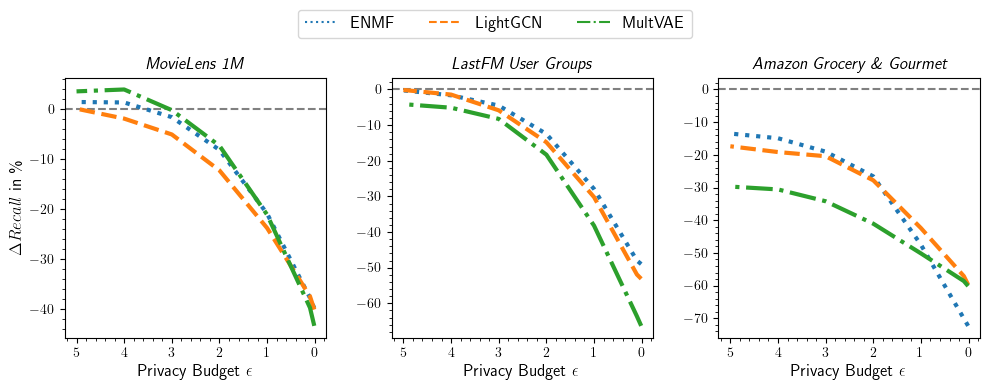

In [6]:
all_eps = [0.01, 0.1, 1, 2, 3, 4, 5]

fig = plt.figure(figsize=(10, 4))
ax1 = plt.subplot2grid(shape=(1,3), loc=(0,0), fig=fig)
ax2 = plt.subplot2grid((1,3), (0,1))
ax3 = plt.subplot2grid((1,3), (0,2))

ax1.axhline(y=0, linestyle="dashed", c="gray")
ax2.axhline(y=0, linestyle="dashed", c="gray")
ax3.axhline(y=0, linestyle="dashed", c="gray")

ax1.plot(all_eps, recall_ml1m["ENMF"][::-1], color="C0", linewidth=3, linestyle="dotted")
ax1.plot(all_eps, recall_ml1m["LightGCN"][::-1], color="C1", linewidth=3, linestyle="dashed")
ax1.plot(all_eps, recall_ml1m["MultiVAE"][::-1], color="C2", linewidth=3, linestyle="dashdot")
ax1.invert_xaxis()

ax2.plot(all_eps, recall_lfm["ENMF"][::-1], color="C0", linewidth=3, linestyle="dotted")
ax2.plot(all_eps, recall_lfm["LightGCN"][::-1], color="C1", linewidth=3, linestyle="dashed")
ax2.plot(all_eps, recall_lfm["MultiVAE"][::-1], color="C2", linewidth=3, linestyle="dashdot")
ax2.invert_xaxis()

ax3.plot(all_eps, recall_amazon["ENMF"][::-1], color="C0", linewidth=3, linestyle="dotted")
ax3.plot(all_eps, recall_amazon["LightGCN"][::-1], color="C1", linewidth=3, linestyle="dashed")
ax3.plot(all_eps, recall_amazon["MultiVAE"][::-1], color="C2", linewidth=3, linestyle="dashdot")
ax3.invert_xaxis()

ax1.set_ylabel(r"$\Delta Recall$ in \%", fontsize="large")
ax1.set_xlabel(r"Privacy Budget $\epsilon$", fontsize="large")
ax2.set_xlabel(r"Privacy Budget $\epsilon$", fontsize="large")
ax3.set_xlabel(r"Privacy Budget $\epsilon$", fontsize="large")

ax1.set_title(r"\emph{MovieLens 1M}")
ax2.set_title(r"\emph{LastFM User Groups}")
ax3.set_title(r"\emph{Amazon Grocery \& Gourmet}")

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())

ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax3.xaxis.set_minor_locator(AutoMinorLocator())

lines = []
lines.append(Line2D([0], [0], color="C0", linestyle="dotted"))
lines.append(Line2D([0], [0], color="C1", linestyle="dashed"))
lines.append(Line2D([0], [0], color="C2", linestyle="dashdot"))
labels = ["ENMF", "LightGCN", "MultVAE"]

fig.legend(lines, labels, ncol=3, loc='upper center', bbox_to_anchor=(0.5, .99), fontsize="large")
fig.tight_layout()
fig.subplots_adjust(top=.8, bottom=0.15, wspace=0.25)
fig.align_ylabels([ax1, ax2, ax3])

#plt.savefig("plots/delta_recall.png", dpi=300)

### Delta ARP

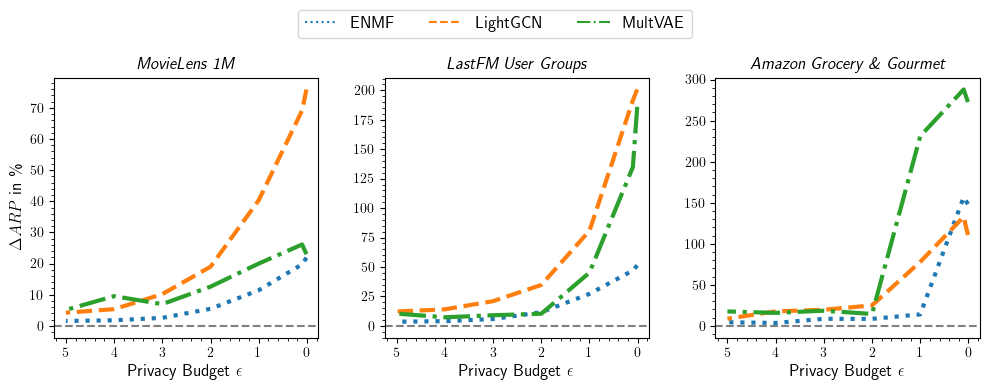

In [7]:
all_eps = [0.01, 0.1, 1, 2, 3, 4, 5]

fig = plt.figure(figsize=(10, 4))
ax1 = plt.subplot2grid(shape=(1,3), loc=(0,0), fig=fig)
ax2 = plt.subplot2grid((1,3), (0,1))
ax3 = plt.subplot2grid((1,3), (0,2))

ax1.axhline(y=0, linestyle="dashed", c="gray")
ax2.axhline(y=0, linestyle="dashed", c="gray")
ax3.axhline(y=0, linestyle="dashed", c="gray")

ax1.plot(all_eps, arp_ml1m["ENMF"][::-1], color="C0", linewidth=3, linestyle="dotted")
ax1.plot(all_eps, arp_ml1m["LightGCN"][::-1], color="C1", linewidth=3, linestyle="dashed")
ax1.plot(all_eps, arp_ml1m["MultiVAE"][::-1], color="C2", linewidth=3, linestyle="dashdot")
ax1.invert_xaxis()

ax2.plot(all_eps, arp_lfm["ENMF"][::-1], color="C0", linewidth=3, linestyle="dotted")
ax2.plot(all_eps, arp_lfm["LightGCN"][::-1], color="C1", linewidth=3, linestyle="dashed")
ax2.plot(all_eps, arp_lfm["MultiVAE"][::-1], color="C2", linewidth=3, linestyle="dashdot")
ax2.invert_xaxis()

ax3.plot(all_eps, arp_amazon["ENMF"][::-1], color="C0", linewidth=3, linestyle="dotted")
ax3.plot(all_eps, arp_amazon["LightGCN"][::-1], color="C1", linewidth=3, linestyle="dashed")
ax3.plot(all_eps, arp_amazon["MultiVAE"][::-1], color="C2", linewidth=3, linestyle="dashdot")
ax3.invert_xaxis()

ax1.set_ylabel(r"$\Delta ARP$ in \%", fontsize="large")
ax1.set_xlabel(r"Privacy Budget $\epsilon$", fontsize="large")
ax2.set_xlabel(r"Privacy Budget $\epsilon$", fontsize="large")
ax3.set_xlabel(r"Privacy Budget $\epsilon$", fontsize="large")

ax1.set_title(r"\emph{MovieLens 1M}")
ax2.set_title(r"\emph{LastFM User Groups}")
ax3.set_title(r"\emph{Amazon Grocery \& Gourmet}")

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())

ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax3.xaxis.set_minor_locator(AutoMinorLocator())

lines = []
lines.append(Line2D([0], [0], color="C0", linestyle="dotted"))
lines.append(Line2D([0], [0], color="C1", linestyle="dashed"))
lines.append(Line2D([0], [0], color="C2", linestyle="dashdot"))
labels = ["ENMF", "LightGCN", "MultVAE"]

fig.legend(lines, labels, ncol=3, loc='upper center', bbox_to_anchor=(0.5, .99), fontsize="large")
fig.tight_layout()
fig.subplots_adjust(top=.8, bottom=0.15, wspace=0.25)
fig.align_ylabels([ax1, ax2, ax3])
#plt.savefig("plots/delta_arp.png", dpi=300)

### Delta PopLift

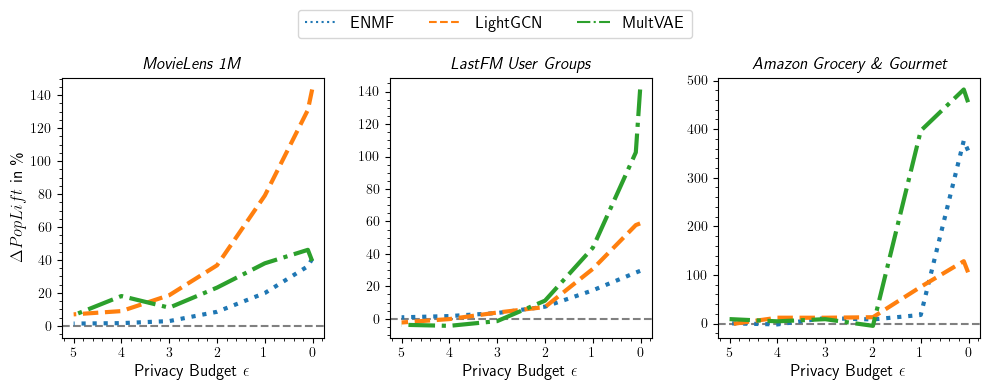

In [8]:
all_eps = [0.01, 0.1, 1, 2, 3, 4, 5]

fig = plt.figure(figsize=(10, 4))
ax1 = plt.subplot2grid(shape=(1,3), loc=(0,0), fig=fig)
ax2 = plt.subplot2grid((1,3), (0,1))
ax3 = plt.subplot2grid((1,3), (0,2))

ax1.axhline(y=0, linestyle="dashed", c="gray")
ax2.axhline(y=0, linestyle="dashed", c="gray")
ax3.axhline(y=0, linestyle="dashed", c="gray")

ax1.plot(all_eps, poplift_ml1m["ENMF"][::-1], color="C0", linewidth=3, linestyle="dotted")
ax1.plot(all_eps, poplift_ml1m["LightGCN"][::-1], color="C1", linewidth=3, linestyle="dashed")
ax1.plot(all_eps, poplift_ml1m["MultiVAE"][::-1], color="C2", linewidth=3, linestyle="dashdot")
ax1.invert_xaxis()

ax2.plot(all_eps, poplift_lfm["ENMF"][::-1], color="C0", linewidth=3, linestyle="dotted")
ax2.plot(all_eps, poplift_lfm["LightGCN"][::-1], color="C1", linewidth=3, linestyle="dashed")
ax2.plot(all_eps, poplift_lfm["MultiVAE"][::-1], color="C2", linewidth=3, linestyle="dashdot")
ax2.invert_xaxis()

ax3.plot(all_eps, poplift_amazon["ENMF"][::-1], color="C0", linewidth=3, linestyle="dotted")
ax3.plot(all_eps, poplift_amazon["LightGCN"][::-1], color="C1", linewidth=3, linestyle="dashed")
ax3.plot(all_eps, poplift_amazon["MultiVAE"][::-1], color="C2", linewidth=3, linestyle="dashdot")
ax3.invert_xaxis()

ax1.set_ylabel(r"$\Delta PopLift$ in \%", fontsize="large")
ax1.set_xlabel(r"Privacy Budget $\epsilon$", fontsize="large")
ax2.set_xlabel(r"Privacy Budget $\epsilon$", fontsize="large")
ax3.set_xlabel(r"Privacy Budget $\epsilon$", fontsize="large")

ax1.set_title(r"\emph{MovieLens 1M}")
ax2.set_title(r"\emph{LastFM User Groups}")
ax3.set_title(r"\emph{Amazon Grocery \& Gourmet}")

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())

ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax3.xaxis.set_minor_locator(AutoMinorLocator())

lines = []
lines.append(Line2D([0], [0], color="C0", linestyle="dotted"))
lines.append(Line2D([0], [0], color="C1", linestyle="dashed"))
lines.append(Line2D([0], [0], color="C2", linestyle="dashdot"))
labels = ["ENMF", "LightGCN", "MultVAE"]

fig.legend(lines, labels, ncol=3, loc='upper center', bbox_to_anchor=(0.5, .99), fontsize="large")
fig.tight_layout()
fig.subplots_adjust(top=.8, bottom=0.15, wspace=0.25)
fig.align_ylabels([ax1, ax2, ax3])
#plt.savefig("plots/delta_pl.png", dpi=300)

## Evaluate PopLift for two User Groups (RQ3b)

In [9]:
# calculate the absolute poplift values for U_low and U_high
def analyze_poplift_usergroups(dataset_name, model_name):
    def _compute_poplift(dirpath, item_popularity, user_profile_popularity, group):
        files = sort_files(dirpath)
        poplifts = []
        for idx, file in enumerate(files):
            with open(dirpath + "/" + file, "rb") as f:
                recommendation_list = pl.load(f)
                arp_g, upp_g = [], []
                for uid, recs in recommendation_list.items():
                    if uid not in group[idx]:
                        continue

                    arp_g.append(np.mean([item_popularity.loc[str(iid)] for iid in recs]))
                    upp_g.append(user_profile_popularity.loc[uid])

                poplifts.append((np.mean(arp_g) - np.mean(upp_g)) / np.mean(upp_g))
        return np.mean(poplifts)

    print()
    print(model_name + " (" + dataset_name + ")")

    df = pd.read_csv("dataset/" + dataset_name + "/" + dataset_name + ".inter", sep="\t")
    df.rename(columns={"user_id:token": "user_id", "item_id:token": "item_id"}, inplace=True)
    df["user_id"] = df["user_id"].astype(str)
    df["item_id"] = df["item_id"].astype(str)
    item_popularity = df.groupby("item_id").size() / df["user_id"].nunique()
    user_profile_pop = df.groupby("user_id")["item_id"].apply(list).apply(lambda iids: np.mean([item_popularity.loc[iid] for iid in iids]))
    cut = int(len(item_popularity) * 0.2)
    head_items = set(item_popularity.sort_values(ascending=False).iloc[:cut].index.tolist())
    frac_pop_items = df.groupby("user_id")["item_id"].apply(set).apply(lambda items: len(items.intersection(head_items)) / len(items))
    frac_pop_items.name = "frac"
    cut = int(len(frac_pop_items) * 0.2)
    low_users = frac_pop_items.sort_values().head(cut).index.tolist()
    high_users = frac_pop_items.sort_values().tail(cut).index.tolist()

    dir = "saved/" + dataset_name + "/" + model_name + "/"

    pl1_nodp = _compute_poplift(dirpath=dir + "nodp", item_popularity=item_popularity, user_profile_popularity=user_profile_pop, group=[low_users] * 5)
    pl2_nodp = _compute_poplift(dirpath=dir + "nodp", item_popularity=item_popularity, user_profile_popularity=user_profile_pop, group=[high_users] * 5)
    print("No DP: %.4f/%.4f (PopLift), %.4f" % (pl1_nodp, pl2_nodp, np.abs(pl1_nodp - pl2_nodp)))

    poplifts1, poplifts2 = [], []
    for eps in [0.01, 0.1, 1, 2, 3, 4, 5][::-1]:
        users, _, _ = _get_impacted_users(dirpath_nodp=dir + "nodp", dirpath_dp=dir + "e" + str(eps))
        group1_and_impacted, group2_and_impacted = [], []
        for users_s in users:
            group1_and_impacted.append(set([uid for uid in users_s]).intersection(low_users))
            group2_and_impacted.append(set([uid for uid in users_s]).intersection(high_users))

        pl1_eps = _compute_poplift(dirpath=dir + "e" + str(eps), item_popularity=item_popularity, user_profile_popularity=user_profile_pop, group=group1_and_impacted)
        pl2_eps = _compute_poplift(dirpath=dir + "e" + str(eps), item_popularity=item_popularity, user_profile_popularity=user_profile_pop, group=group2_and_impacted)

        poplifts1.append(pl1_eps)
        poplifts2.append(pl2_eps)

        print("eps: %f -> %.4f/%.4f (PopLift), %.4f (Gap)" % (eps, poplifts1[-1], poplifts2[-1], np.abs(poplifts1[-1] - poplifts2[-1])))

    return poplifts1, poplifts2

for d in ["ml-1m", "LFM-3k", "grocery"]:
    for m in ["ENMF", "LightGCN", "MultiVAE"]:
        analyze_poplift_usergroups(dataset_name=d, model_name=m)


ENMF (ml-1m)
No DP: 1.0923/0.4800 (PopLift), 0.6124
eps: 5.000000 -> 1.0940/0.4903 (PopLift), 0.6037 (Gap)
eps: 4.000000 -> 1.1028/0.4901 (PopLift), 0.6127 (Gap)
eps: 3.000000 -> 1.1163/0.4940 (PopLift), 0.6223 (Gap)
eps: 2.000000 -> 1.2088/0.5147 (PopLift), 0.6941 (Gap)
eps: 1.000000 -> 1.3658/0.5612 (PopLift), 0.8046 (Gap)
eps: 0.100000 -> 1.5276/0.6445 (PopLift), 0.8831 (Gap)
eps: 0.010000 -> 1.5749/0.6662 (PopLift), 0.9087 (Gap)

LightGCN (ml-1m)
No DP: 0.4225/0.5296 (PopLift), 0.1072
eps: 5.000000 -> 0.4625/0.5566 (PopLift), 0.0940 (Gap)
eps: 4.000000 -> 0.4946/0.5494 (PopLift), 0.0548 (Gap)
eps: 3.000000 -> 0.5823/0.5813 (PopLift), 0.0010 (Gap)
eps: 2.000000 -> 0.7447/0.6206 (PopLift), 0.1241 (Gap)
eps: 1.000000 -> 1.1633/0.7265 (PopLift), 0.4368 (Gap)
eps: 0.100000 -> 1.7767/0.8415 (PopLift), 0.9352 (Gap)
eps: 0.010000 -> 1.9298/0.8651 (PopLift), 1.0647 (Gap)

MultiVAE (ml-1m)
No DP: 0.6247/0.4901 (PopLift), 0.1347
eps: 5.000000 -> 0.6538/0.5227 (PopLift), 0.1311 (Gap)
eps: 4.0